In [308]:
import imageio
import math

import numpy as np
import scipy as sp

from PIL import Image
from scipy import fft, ifft, conj

# Frequency Based Registration

Registration by sending the images into the Fourier domain and performing phase correlation on them. In the Inverse Fourier transform of this operation, the peak is where the images correlate the best. The point found represents the upper left corner of the moving image instead of the center as it does in the area based methods.

An interesting note on [`scipy.fftpack.fft`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.fftpack.fft.html):  
    
> This function is most efficient when n is a power of two, and least efficient when n is prime.

In [466]:
def cross_power(i1, i2):
#     f1 = fft(i1)
#     f2 = fft(i2)
    f1 = np.fft.fft2(i1)
    f2 = np.fft.fft2(i2)
    return (f1 * conj(f2)) / abs(f2 * conj(f2)) # faroosh
#     return (f2 * conj(f1)) / abs(f1 * f2) # msft
#     return (f1 * conj(f2)) / abs(f1 * conj(f2)) # mosaic survey

def convolve(im, template, op):
    h_len, w_len = im.shape
    th, tw = template.shape
    offset_h, offset_w = (int(th/2), int(tw/2))
    op_res = np.zeros((h_len, w_len))
    for i in range(h_len-th+1):
        for j in range(w_len-tw+1):
            # slice im to be the area under the template
            op_res[i+offset_h, j+offset_w] = op(im[i:i+th, j:j+tw], template)
    return op_res

In [488]:
import matplotlib.pyplot as plt

def clamp(x, mn, mx):
    return max(mn, min(x, mx))

def show_registration(ref, mov, correlation, coord):
    fig, (a, b, corr) = plt.subplots(1, 3, figsize=(10, 18))
    
    a.imshow(ref, cmap='gray')
    a.set_title('Reference')
    a.plot(coord[0], coord[1], 'ro')
    
    b.imshow(mov, cmap='gray')
    b.set_title('Moving')
    
    # uncomment if you want to see the impulse peak.
#     w = 10
#     sy = clamp(y-w, 0, correlation.shape[1])
#     ey = clamp(y+w, 0, correlation.shape[1])
#     sx = clamp(x-w, 0, correlation.shape[0])
#     ex = clamp(x+w, 0, correlation.shape[0])
#     corr.imshow(np.real(correlation)[sy:ey,sx:ex])
    corr.imshow(np.real(correlation))  
    corr.set_title('phase-correlation')
    plt.show()

In [477]:
# s = 1024
s = 2048
newsize = (s,s)
temp1 = Image.open('../data/T1_segment_1.tif').resize(newsize)
temp2 = Image.open('../data/T1_segment_2.tif').resize(newsize)

In [478]:
dtype = 'float64'
im1 = np.array(temp1).astype(dtype)
# p = int(im1.shape[0])
# im1 = np.pad(im1, ((p,p), (p,p)), 'constant', constant_values=(0,0))
im2 = np.array(temp2).astype(dtype)

# cps = convolve(im1, im2, cross_power)
cps = np.fft.ifft2(cross_power(im1, im2))
y,x = np.unravel_index(np.argmax(cps), cps.shape)
x,y

(1024, 0)

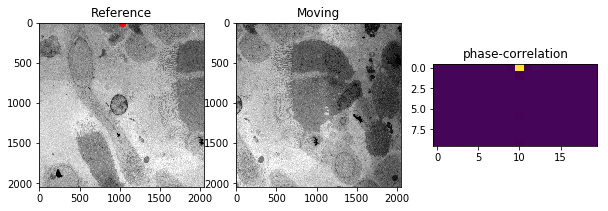

In [489]:
show_registration(im1, im2, cps, (x,y))